# Modeling
Data is separated on a candidate-basis to observe polls prior to and before a candidate suspends their campaign.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import numpy as np
import pandas as pd
import os
import math

import stats

## Read File Written in 02-DataCleaning

In [2]:
candidates = pd.read_csv('candidates.csv', index_col='name')

## Read File Written in 03-Modeling

In [3]:
polls = pd.read_csv('bootPolls.csv')

Convert date from string to datetime.

In [4]:
polls.date = pd.Series(pd.DatetimeIndex(polls.date))
polls.index = polls.date
del polls['date']

candidates.date = pd.to_datetime(candidates.date)

stats.Equals100(polls)

## Data Modeling Functions Defintions

### Before Campaign Suspension

Function to get average polling for a single active candidate before a candidate drops out.

In [5]:
def getBeforeAverage(pollGroup, dropout, cand):
    """Returns average polling for a single candidate in the week prior to another candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator. Also used to as denominator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        tot += pollGroup[cand][count]
        count += 1
        iterDate = pollGroup.index[count]

    return tot/count

Function to create list of average polling for all other candidates before a candidate drops out.

In [6]:
def BeforeAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week prior to another
       candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:    # for each candidate
        averages.append(getBeforeAverage(pollGroup, dropout, c))
        
    return averages

### After Campaign Suspension

Function to retrieve difference in days since date of suspension/dropout.

In [7]:
def dateDiff(dropout, iterDate):
    """Returns difference in days between date iterator and the date a candidate dropped out of the race.
    
    Parameters
    ----------
    dropout : str
        The name of the candidate that dropped out.
    iterDate : str
        The name of the candidate whose average polling is being calculated.
    """
    return (iterDate - candidates['date'][dropout]).days

Function to get weighted average polling for a single active candidate after a candidate drops out. Weight is determined by days after campaign suspension; the further away from the date of suspension, the more weight the polling data holds.

In [8]:
def getAfterAverage(pollGroup, dropout, cand):
    """Returns average polling for a candidate in the week after another candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator
    dateCount = 0                       # used to as denomiator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    # Get the date iterator to the dropout date
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        count += 1
        iterDate = pollGroup.index[count]
    
    # Iterates through poll grouping conducted in the week after a candidate dropped out of the race
    while count < len(pollGroup.index):
        iterDate = pollGroup.index[count]
        diff = dateDiff(dropout, iterDate)
        candCount = pollGroup[cand][count]
        
        if math.isnan(candCount) == False:    # only uses numbers
            tot += candCount * diff           # gives weight to polls conducted further away from the date of dropping
            dateCount += diff
        count += 1
        
    if dateCount == 0:    # can't divide by zero, so just return 0 if no polls conducted after date of dropping
        return float('nan')
    else:
        return tot/dateCount

Function to get weighted average polling for all other candidtates after a candidate drops out.

In [9]:
def AfterAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week after another
       candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:
        averages.append(getAfterAverage(pollGroup, dropout, c))
    return averages

## Data Modeling Functions Apllications

Create a list of dictionaries holding the name of each candidate that suspended their campaign and the DataFrames of polling data from a week before to a week after that candidate suspended their campaign.

In [10]:
pollList = []

pollIndex = [c for c in candidates.index if candidates.dropped[c] == True]
for p in pollIndex:
    pollList.append({'name': p, 'poll': stats.BiWeekPolling(polls, candidates, p)})

Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week prior to a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week before the candidate in the row dropped out.

In [11]:
WeekBeforeDrop = []

for p in range(len(pollList)):
    WeekBeforeDrop.append(BeforeAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingBeforeDrop = pd.DataFrame(WeekBeforeDrop, columns=polls.columns, index=pollIndex)
PollingBeforeDrop.index.names = ['name']
stats.Equals100(PollingBeforeDrop)
PollingBeforeDrop

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
name,,,,,,,,,,,,,
Bush,38.112456,19.471322,6.027467,5.028578,7.996444,NaN,NaN,NaN,NaN,NaN,13.080211,NaN,10.283522
Carson,41.205185,18.053611,7.572593,NaN,7.952593,NaN,NaN,NaN,NaN,NaN,16.318889,NaN,8.897130
Christie,35.735759,20.663870,4.440500,4.319574,7.502222,2.447630,2.014074,0.021111,NaN,NaN,14.819981,NaN,8.035278
Fiorina,35.735759,20.663870,4.440500,4.319574,7.502222,2.447630,2.014074,0.021111,NaN,NaN,14.819981,NaN,8.035278
Gilmore,38.605704,19.674944,4.215296,5.349278,8.485000,NaN,NaN,0.021111,NaN,NaN,12.615963,NaN,11.032704
Huckabee,38.142733,17.801156,4.511800,4.461467,7.112444,1.960189,1.567889,0.154667,1.744,2.667433,11.389767,0.775944,7.710511
Paul,39.026667,17.884306,4.610417,4.275000,6.967500,2.420278,1.646944,0.269167,NaN,2.642083,11.998611,0.663472,7.595556
Rubio,43.509370,21.995167,9.926704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.380722,NaN,13.188037
Santorum,39.026667,17.884306,4.610417,4.275000,6.967500,2.420278,1.646944,0.269167,NaN,2.642083,11.998611,0.663472,7.595556


Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week after a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week after the candidate in the row dropped out.

In [12]:
WeekAfterDrop = []

for p in range(len(pollList)):
    WeekAfterDrop.append(AfterAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingAfterDrop = pd.DataFrame(WeekAfterDrop, columns=polls.columns, index=pollIndex)
PollingAfterDrop.index.names = ['name']
stats.Equals100(PollingAfterDrop)
PollingAfterDrop

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
name,,,,,,,,,,,,,
Bush,37.183442,19.478322,8.406619,NaN,7.451806,NaN,NaN,NaN,NaN,NaN,15.223864,NaN,12.255947
Carson,44.285663,21.878911,10.271937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.684189,NaN,11.879300
Christie,37.633174,19.227986,7.229041,4.503833,7.910580,NaN,NaN,0.016667,NaN,NaN,13.446138,NaN,10.032582
Fiorina,37.633174,19.227986,7.229041,4.503833,7.910580,NaN,NaN,0.016667,NaN,NaN,13.446138,NaN,10.032582
Gilmore,37.385325,19.330885,7.365175,4.404654,7.967341,NaN,NaN,NaN,NaN,NaN,13.544377,NaN,10.002243
Huckabee,35.967944,19.373975,4.595333,3.915737,7.107778,2.490561,1.823939,0.075152,NaN,2.748833,15.108924,0.34,6.451823
Paul,38.696925,19.723603,4.335808,5.509058,8.528083,2.466255,2.120741,0.021333,NaN,NaN,12.445089,NaN,6.153105
Rubio,42.045042,26.107354,14.440049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.407556
Santorum,38.696925,19.723603,4.335808,5.509058,8.528083,2.466255,2.120741,0.021333,NaN,NaN,12.445089,NaN,6.153105


## Testing
Confirm DataFrame snippets are working as expected. Test on Jeb Bush.

Display date of drop.

In [13]:
candidates['date']['Bush']

Timestamp('2016-02-16 00:00:00')

Confirm data is saved properly after being pushed to a list of dictionaries.

In [14]:
BushPolls1 = polls[(polls.index > candidates['date']['Bush'] - datetime.timedelta(days=7)) \
     & (polls.index < candidates['date']['Bush'] + datetime.timedelta(days=9))]
BushPoll2 = pollList[1]['poll']
assert all(BushPolls1) == all(BushPoll2)

Display polling for candidates a week before to a week after Jeb Bush dropped.

In [15]:
BushPolls1

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
date,,,,,,,,,,,,,
2016-02-10,36.002556,22.069111,3.595389,5.750389,9.405000,2.523444,2.421111,0.030000,NaN,NaN,13.110500,NaN,5.092500
2016-02-11,42.254444,17.839722,4.934167,6.365556,8.695000,NaN,NaN,0.016667,NaN,NaN,10.313333,NaN,9.581111
2016-02-14,38.080778,18.489778,6.722944,3.897944,7.628889,NaN,NaN,NaN,NaN,NaN,13.142556,NaN,12.037111
2016-02-15,37.923611,19.369167,7.387222,4.670000,5.581111,NaN,NaN,NaN,NaN,NaN,15.432778,NaN,9.636111
2016-02-16,36.300889,19.588833,7.497611,4.459000,8.672222,NaN,NaN,NaN,NaN,NaN,13.401889,NaN,10.079556
2016-02-17,37.651722,19.438000,7.502889,NaN,8.970556,NaN,NaN,NaN,NaN,NaN,12.686056,NaN,13.750778
2016-02-21,37.032000,19.444111,7.738722,NaN,7.338889,NaN,NaN,NaN,NaN,NaN,14.271333,NaN,14.174944
2016-02-22,36.930556,18.000278,10.500278,NaN,7.412222,NaN,NaN,NaN,NaN,NaN,17.796944,NaN,9.359722
2016-02-24,37.409222,20.613278,7.366778,NaN,7.362222,NaN,NaN,NaN,NaN,NaN,14.206611,NaN,13.041889


Confirm polling data sums up to 100 for each poll

In [16]:
sum(BushPolls1.loc['2016-02-22'].dropna())

100.0

In [17]:
assert sum(BushPolls1.loc['2016-02-10'].dropna()) == 100
assert sum(BushPolls1.loc['2016-02-22'].dropna()) == 100

Confirm polling before drop is accurate.

In [18]:
BushBeforeAvgs1 = BeforeAverages(BushPolls1, 'Bush')
BushBeforeAvgs2 = PollingBeforeDrop.loc['Bush']
assert all(BushBeforeAvgs1) == all(list(BushBeforeAvgs2))
assert sum(BushBeforeAvgs2.dropna()) == 100

Display candidates' average polling data in the week before Jeb Bush suspended his campaign.

In [19]:
print(BushBeforeAvgs1)

[38.112455555555549, 19.47132222222222, 6.0274666666666672, 5.0285777777777776, 7.9964444444444451, nan, nan, nan, nan, nan, 13.080211111111112, nan, 9.2852777777777753]


Confrim polling after drop is accurate.

In [20]:
BushAfterAvgs1 = AfterAverages(BushPolls1, 'Bush')
BushAfterAvgs2 = PollingAfterDrop.loc['Bush']
assert all(BushAfterAvgs1) == all(list(BushAfterAvgs2))

Display candidates' average polling data in the week after Jeb Bush suspended his campaign.

In [21]:
print(BushAfterAvgs1)

[37.18344166666666, 19.478322222222225, 8.4066194444444449, nan, 7.4518055555555547, nan, nan, nan, nan, nan, 15.223863888888889, nan, 12.255947222222222]


Polling data sums up to 100.

In [22]:
for p in range(len(PollingBeforeDrop.index)):
    assert sum(PollingBeforeDrop.iloc[p].dropna()) == 100
    
for p in range(len(PollingAfterDrop.index)):
    assert sum(PollingAfterDrop.iloc[p].dropna()) == 100

Graph Jeb Bush's data.

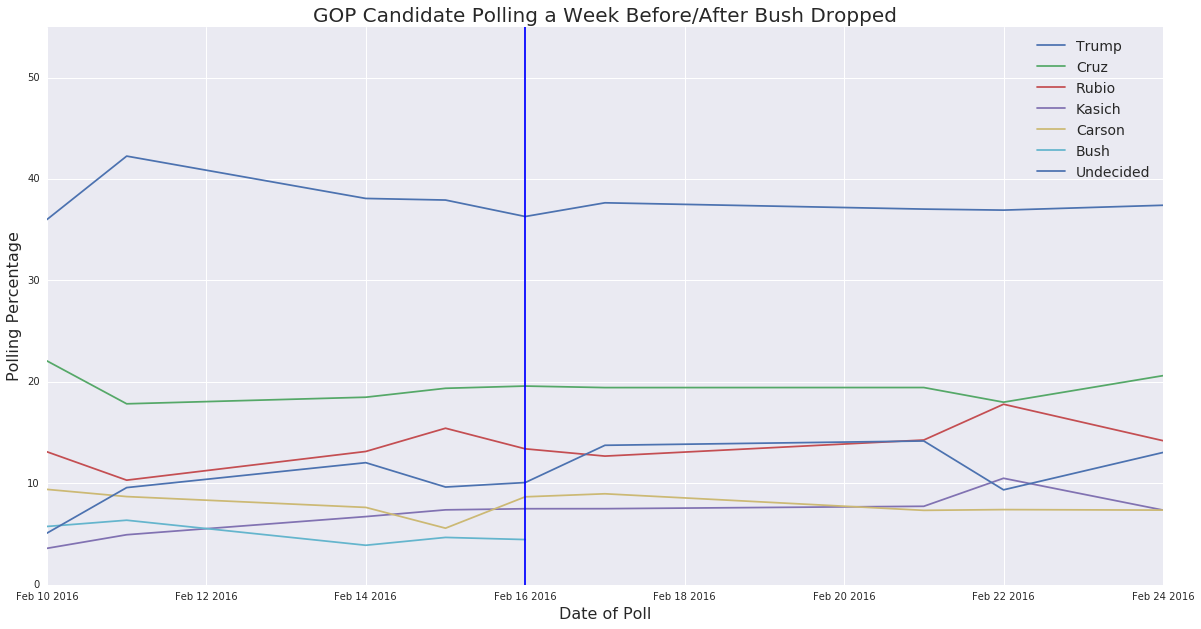

In [23]:
plt.figure(figsize=(20,10))

plt.plot(BushPolls1.Trump)
plt.plot(BushPolls1.Cruz)
plt.plot(BushPolls1.Rubio)
plt.plot(BushPolls1.Kasich)
plt.plot(BushPolls1.Carson)
plt.plot(BushPolls1.Bush)
plt.plot(BushPolls1.Undecided)

plt.axvline(candidates['date']['Bush'])

plt.title("GOP Candidate Polling a Week Before/After Bush Dropped", size=20)
plt.xlabel("Date of Poll", size=16)
plt.ylabel("Polling Percentage", size=16)

# y limits are a little greater than needed to display the legend without blocking out data
plt.ylim(0, 55)
plt.legend(fontsize=14)

## Write to File
Write the DataFrames PollingBeforeDrop and PollingAfterDrop to two separte files to be analyzed in 05-Analysis.ipynb

In [24]:
PollingBeforeDrop.to_csv('PollingBeforeDrop.csv')
PollingAfterDrop.to_csv('PollingAfterDrop.csv')